## Table of content:
* [1. Load data](#LoadData)
* [2. Data preprocessing](#DataPreprocessing)
* [3. Features and target](#FeaturesAndTarget)
* [4. Building Linear Regression Model](#BuildingLinearRegressionModel)
* [5. Model Evaluation](#ModelEvaluation)

In [1190]:
from linearmodels.asset_pricing import LinearFactorModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
import pandas as pd
import os.path
import numpy as np
from scipy.stats import spearmanr

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

## 1. Load data <a class="anchor" id="LoadData"></a>

In [1191]:
START = '2000'
END = '2018'

### 1.1 Data source: Prices
https://data.nasdaq.com/tables/WIKIP/WIKI-PRICES/

In [1192]:
prices = pd.read_csv("regression/prices-{}-{}.csv".format(START, END), parse_dates=[
    'date'], index_col=['date'], infer_datetime_format=True)

prices.index.names = ["Date"]
prices

,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,37.06,23.5,NaN,NaN,NaN,NaN,3.7025,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,36.50,22.5,NaN,NaN,NaN,NaN,3.5475,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,37.13,23.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,35.25,22.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,38.00,21.5,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,69.400000,47.95,54.09,60.80,47.370000,26.71,39.050000,115.24,171.270000,32.46,...,4.28,4.53,NaN,NaN,NaN,3.94,15.66,NaN,84.10,23.95
2018-03-22,67.470000,44.92,52.31,60.18,45.940000,25.96,38.550000,111.71,168.845000,32.52,...,4.19,4.52,NaN,NaN,NaN,3.81,15.27,NaN,82.06,23.35
2018-03-23,66.060000,44.71,51.01,58.35,45.300000,25.36,37.200000,110.84,164.940000,31.78,...,4.05,4.40,NaN,NaN,NaN,3.80,15.12,NaN,80.60,23.55


### 1.2 Data source: Tickers and Metadata
https://data.nasdaq.com/tables/SF1/SHARADAR-TICKERS

In [1193]:
equities = pd.read_csv('regression/SHARADAR-TICKERS.csv',  index_col=['ticker'])
equities

,table,permaticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,sicindustry,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
ticker,,,,,,,,,,,,,,,,,,,,,
A,SF1,196290,Agilent Technologies Inc,NYSE,N,Domestic Common Stock,00846U101,3826.0,Manufacturing,Laboratory Analytical Instruments,...,USD,California; U.S.A,2021-12-17,2014-09-26,1999-11-18,2021-12-27,1997-06-30,2021-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.agilent.com
AA,SF1,124392,Alcoa Corp,NYSE,N,Domestic Common Stock,013872106,3334.0,Manufacturing,Primary Production Of Aluminum,...,USD,Pennsylvania; U.S.A,2021-10-28,2016-11-01,2016-11-01,2021-12-27,2014-12-31,2021-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.alcoa.com
AAAB,SF1,122827,Admiralty Bancorp Inc,NASDAQ,Y,Domestic Common Stock,007231103,6022.0,Finance Insurance And Real Estate,State Commercial Banks,...,USD,Florida; U.S.A,2019-07-29,2017-09-09,1998-09-25,2003-01-28,1997-09-30,2002-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
AAAGY,SF1,120538,Altana Aktiengesellschaft,NYSE,Y,ADR Common Stock,02143N103,2834.0,Manufacturing,Pharmaceutical Preparations,...,EUR,Jordan,2019-05-17,2018-02-13,2002-05-22,2010-08-12,2000-12-31,2005-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
AAAP,SF1,155760,Advanced Accelerator Applications SA,NASDAQ,Y,ADR Common Stock,00790T100,2834.0,Manufacturing,Pharmaceutical Preparations,...,EUR,France,2020-10-08,2016-05-19,2015-11-11,2018-02-09,2012-12-31,2017-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NEWCQ,SF1,177166,New Century Financial Corp,NYSE,Y,Domestic Common Stock,6435EV108 64352D101,6798.0,Finance Insurance And Real Estate,Real Estate Investment Trusts,...,USD,California; U.S.A,2019-04-26,2015-07-20,1997-06-26,2008-08-04,1996-12-31,2006-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
NEWI,SF1,102428,New West Eyeworks Inc,NASDAQ,Y,Domestic Common Stock,649156106,5990.0,Retail Trade,Retail-Retail Stores Nec,...,USD,Arkansas; U.S.A,2021-01-21,2021-01-20,1993-12-23,1998-10-20,1996-12-31,1998-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
NEWM,SF1,191403,New Media Investment Group Inc,NYSE,Y,Domestic Common Stock,64704V106,2711.0,Manufacturing,Newspapers: Publishing Or Publishing & Printing,...,USD,New York; U.S.A,2020-10-21,2015-05-30,2014-02-04,2019-11-19,2011-12-31,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN


### 1.3 Data source: Risk factors (Fama/French 5 factors)
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

In [1194]:
ff5_monthly = pd.read_csv("regression/ff_factor_data-{}-{}.csv".format(START, END), 
                          parse_dates=['Date'], 
                          index_col=['Date'])
ff_factor_data = ff5_monthly.to_period('M')
ff_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2000-01,-4.74,4.45,-1.89,-6.29,4.74,0.41
2000-02,2.45,18.38,-9.81,-18.76,-0.35,0.43
2000-03,5.20,-15.39,8.23,11.82,-1.61,0.47
2000-04,-6.40,-4.96,7.25,7.67,5.62,0.46
2000-05,-4.42,-3.87,4.83,4.18,1.32,0.50
...,...,...,...,...,...,...
2018-08,3.44,0.63,-3.98,-0.29,-2.64,0.16
2018-09,0.06,-2.50,-1.70,0.67,1.28,0.15
2018-10,-7.68,-4.50,3.43,1.00,3.54,0.19


## 2. Data preprocessing <a class="anchor" id="DataPreprocessing"></a>

### 2.1. Clean prices data

#### 2.1.1. Delete empty rows

In [1195]:
prices.isnull().sum()

A        120
AA      4355
AAL     1561
AAMC    3382
AAN      120
        ... 
ZNGA    3129
ZOES    3710
ZQK      760
ZTS     3410
ZUMZ    1462
Length: 3199, dtype: int64

In [1196]:
print("before: {}".format(prices.shape))
prices = prices.dropna(thresh=2, axis=0)
print("after: {}".format(prices.shape))
prices.isnull().sum()

before: (4706, 3199)
after: (4611, 3199)


A         25
AA      4260
AAL     1466
AAMC    3287
AAN       25
        ... 
ZNGA    3034
ZOES    3615
ZQK      665
ZTS     3315
ZUMZ    1367
Length: 3199, dtype: int64

#### 2.1.2. Drop columns with not enough prices

In [1197]:
print("before: {}".format(prices.shape))
prices = prices.dropna(thresh=4500, axis=1)
print("after: {}".format(prices.shape))
prices.isnull().sum()

before: (4611, 3199)
after: (4611, 1466)


A       25
AAN     25
AAON    25
AAPL    26
ABAX    25
        ..
YUM     25
ZBRA    25
ZEUS    25
ZION    25
ZIXI    25
Length: 1466, dtype: int64

#### 2.1.3. Fillna with mean values

In [1198]:
prices = prices.fillna(prices.mean())
prices.isnull().sum()

A       0
AAN     0
AAON    0
AAPL    0
ABAX    0
       ..
YUM     0
ZBRA    0
ZEUS    0
ZION    0
ZIXI    0
Length: 1466, dtype: int64

### 2.2. Clean Metadata

#### 2.2.1 Drop rows with no sector

In [1199]:
equities.isnull().sum()

table                 0
permaticker           0
name                  0
exchange              0
isdelisted            0
category              0
cusips              111
siccode              15
sicsector            15
sicindustry          15
famasector        10000
famaindustry         53
sector              126
industry            126
scalemarketcap       79
scalerevenue        739
relatedtickers     5567
currency              0
location             12
lastupdated           0
firstadded            0
firstpricedate        0
lastpricedate         0
firstquarter          0
lastquarter           0
secfilings            0
companysite        6970
dtype: int64

In [1200]:
print("Before: {}".format(equities.shape))
equities['sector'].replace('', np.nan, inplace=True)
equities.dropna(subset=['sector'], inplace=True)
print("After: {}".format(equities.shape))
equities.isnull().sum()

Before: (10000, 27)
After: (9874, 27)


table                0
permaticker          0
name                 0
exchange             0
isdelisted           0
category             0
cusips             111
siccode              4
sicsector            4
sicindustry          4
famasector        9874
famaindustry        26
sector               0
industry             0
scalemarketcap      78
scalerevenue       738
relatedtickers    5491
currency             0
location             6
lastupdated          0
firstadded           0
firstpricedate       0
lastpricedate        0
firstquarter         0
lastquarter          0
secfilings           0
companysite       6846
dtype: int64

### 2.3. Filter prices
Filter prices where stock symbol (ticker) belong to the Financial sector

In [1201]:
equities = equities[equities["sector"].str.contains('Financ')]
equitiesFiltered = equities.filter(prices.columns, axis=0)
print("Metadata before: {}".format(equities.shape))
print("Metadata after: {}".format(equitiesFiltered.shape))

print("Prices before: {}".format(prices.shape))
prices = prices.filter(equitiesFiltered.index).dropna(how='all', axis=1)
print("Prices after: {}".format(prices.shape))
prices

Metadata before: (1485, 27)
Metadata after: (148, 27)
Prices before: (4611, 1466)
Prices after: (4611, 148)


,ABCB,ACGL,AFG,AFL,AGM,AIG,AJG,ALL,AMG,AMNB,...,MET,MKL,MMC,MS,MSFG,MSL,MTB,MTG,NAVG,NBTB
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,6.210468,3.833333,10.674085,16.178280,14.564787,1012.940107,8.443412,15.043368,24.441299,9.230498,...,34.861929,148.90,30.128761,42.022245,7.835192,4.223600,26.341078,50.761385,4.846778,8.295930
2000-01-04,6.141142,3.813333,10.437914,15.748064,14.187656,961.561913,8.061249,14.563261,22.485995,8.357343,...,34.861929,144.70,28.774623,38.909486,8.046954,4.282959,25.494919,48.706376,5.468160,7.875949
2000-01-05,6.066039,4.166667,10.201743,15.748064,13.433394,966.436504,8.135559,15.081777,21.907385,8.232607,...,34.861929,146.00,27.939837,37.490068,8.046954,4.250997,25.608302,48.039165,5.468160,7.974463
2000-01-06,6.141142,4.126667,10.437914,15.975826,13.953835,993.441741,8.079827,15.126587,22.612359,7.733661,...,34.861929,146.10,29.596664,38.209116,7.835192,4.250997,25.908280,48.145919,5.468160,7.777435
2000-01-07,6.210468,4.353333,10.859648,16.290353,14.330965,1067.535531,8.392988,15.683512,23.151065,8.297470,...,34.861929,150.00,30.537969,39.395077,8.046954,4.109449,26.369586,47.932412,5.592436,8.166306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,56.050000,85.820000,115.300000,45.370000,87.660000,55.840000,70.270000,96.840000,192.260000,39.400000,...,47.220000,1170.20,84.490000,57.110000,39.690000,13.400000,189.650000,12.550000,58.100000,36.950000
2018-03-22,53.850000,84.360000,111.770000,44.370000,87.570000,54.810000,68.570000,94.650000,185.170000,38.550000,...,45.710000,1155.60,82.430000,54.640000,38.430000,12.950000,182.450000,12.580000,57.300000,36.020000
2018-03-23,52.150000,83.410000,109.250000,43.350000,84.100000,53.410000,66.690000,92.250000,180.920000,37.200000,...,44.080000,1151.74,80.540000,52.070000,36.880000,12.650000,177.510000,12.250000,56.200000,34.630000


### 2.4. Calculate monthly returns

In [1202]:
stock_returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
stock_returns

,ABCB,ACGL,AFG,AFL,AGM,AIG,AJG,ALL,AMG,AMNB,...,MET,MKL,MMC,MS,MSFG,MSL,MTB,MTG,NAVG,NBTB
Date,,,,,,,,,,,,,,,,,,,,,
2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02,-2.517275,4.309166,-1.777362,-15.676336,-13.394683,-15.287356,-4.874419,-14.384457,13.514294,-5.555556,...,0.000000,-20.243902,-17.680851,6.324528,0.246598,-5.405405,-9.913551,-19.659904,-1.915826,-5.814093
2000-03,2.892152,7.344262,36.333333,24.617068,-8.500590,23.881877,28.103524,20.924327,20.834393,-15.422059,...,0.000000,11.238532,42.543293,17.660420,-5.633803,0.563063,21.002710,16.693419,5.870130,11.538462
2000-04,-1.838966,-5.986561,-10.325150,7.133450,-3.225806,0.182648,14.615385,-0.251995,-15.515789,5.684211,...,-65.649981,-0.343643,-10.260378,-7.164000,0.000000,-4.228571,-1.623740,9.605685,-4.317959,-27.172414
2000-05,0.000000,-2.534113,9.827044,6.084135,1.266667,2.689152,3.865772,14.150839,-13.555943,-8.698539,...,23.792271,0.206897,13.129058,-6.840391,-3.460761,-0.835322,-1.263959,3.726320,-10.871795,-4.270033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11,3.549061,-4.967884,-0.407622,4.470139,0.013470,-7.197028,3.947576,9.375666,6.525469,5.108557,...,0.920202,2.084294,3.706907,3.220000,4.934996,4.580153,1.307190,2.237762,-11.206897,1.835343
2017-12,-2.822581,-4.139825,3.312393,0.159744,5.373737,-0.633756,-3.873614,1.996883,3.312025,-6.925881,...,-5.812221,2.911735,-3.026331,1.666344,-8.192162,-3.284672,1.207458,-3.488372,-5.436893,-5.252317
2018-01,11.099585,0.187287,4.422333,0.478469,2.569018,7.284324,7.964602,-5.672811,-2.738124,-2.349869,...,-4.924842,0.751451,2.617029,7.775872,8.372349,6.792453,11.573776,5.031892,-0.205339,0.298913


#### 2.4.1 Clean monthly returns

In [1203]:
print("before: {}".format(stock_returns.shape))
stock_returns = stock_returns.dropna(thresh=2, axis=0)
print("after: {}".format(stock_returns.shape))
print(stock_returns.isnull().sum())
stock_returns

before: (219, 148)
after: (218, 148)
ABCB    0
ACGL    0
AFG     0
AFL     0
AGM     0
       ..
MSL     0
MTB     0
MTG     0
NAVG    0
NBTB    0
Length: 148, dtype: int64


,ABCB,ACGL,AFG,AFL,AGM,AIG,AJG,ALL,AMG,AMNB,...,MET,MKL,MMC,MS,MSFG,MSL,MTB,MTG,NAVG,NBTB
Date,,,,,,,,,,,,,,,,,,,,,
2000-02,-2.517275,4.309166,-1.777362,-15.676336,-13.394683,-15.287356,-4.874419,-14.384457,13.514294,-5.555556,...,0.000000,-20.243902,-17.680851,6.324528,0.246598,-5.405405,-9.913551,-19.659904,-1.915826,-5.814093
2000-03,2.892152,7.344262,36.333333,24.617068,-8.500590,23.881877,28.103524,20.924327,20.834393,-15.422059,...,0.000000,11.238532,42.543293,17.660420,-5.633803,0.563063,21.002710,16.693419,5.870130,11.538462
2000-04,-1.838966,-5.986561,-10.325150,7.133450,-3.225806,0.182648,14.615385,-0.251995,-15.515789,5.684211,...,-65.649981,-0.343643,-10.260378,-7.164000,0.000000,-4.228571,-1.623740,9.605685,-4.317959,-27.172414
2000-05,0.000000,-2.534113,9.827044,6.084135,1.266667,2.689152,3.865772,14.150839,-13.555943,-8.698539,...,23.792271,0.206897,13.129058,-6.840391,-3.460761,-0.835322,-1.263959,3.726320,-10.871795,-4.270033
2000-06,-1.339737,-0.400000,-11.130995,-11.124009,-4.147465,4.351687,9.159580,-17.409057,31.104065,1.090909,...,2.731707,-2.546456,-6.367713,16.433566,0.000000,-2.429715,4.046243,-8.192090,3.567319,7.566915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11,3.549061,-4.967884,-0.407622,4.470139,0.013470,-7.197028,3.947576,9.375666,6.525469,5.108557,...,0.920202,2.084294,3.706907,3.220000,4.934996,4.580153,1.307190,2.237762,-11.206897,1.835343
2017-12,-2.822581,-4.139825,3.312393,0.159744,5.373737,-0.633756,-3.873614,1.996883,3.312025,-6.925881,...,-5.812221,2.911735,-3.026331,1.666344,-8.192162,-3.284672,1.207458,-3.488372,-5.436893,-5.252317
2018-01,11.099585,0.187287,4.422333,0.478469,2.569018,7.284324,7.964602,-5.672811,-2.738124,-2.349869,...,-4.924842,0.751451,2.617029,7.775872,8.372349,6.792453,11.573776,5.031892,-0.205339,0.298913


### 2.5. Compute excess returns for target
Fama–MacBeth model works with excess returns

In [1204]:
excess_returns = stock_returns.sub(ff_factor_data.RF, axis=0)
excess_returns.info()
print("before: {}".format(excess_returns.shape))
excess_returns = excess_returns.dropna(thresh=2, axis=0)
print("after: {}".format(excess_returns.shape))

excess_returns.describe()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 228 entries, 2000-01 to 2018-12
Freq: M
Columns: 148 entries, ABCB to NBTB
dtypes: float64(148)
memory usage: 265.4 KB
before: (228, 148)
after: (218, 148)


,ABCB,ACGL,AFG,AFL,AGM,AIG,AJG,ALL,AMG,AMNB,...,MET,MKL,MMC,MS,MSFG,MSL,MTB,MTG,NAVG,NBTB
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,...,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,1.357010,1.312231,1.257022,0.823801,2.078286,0.532739,1.141721,1.049685,1.420970,0.764054,...,0.566682,0.900769,0.585150,0.528093,1.039682,0.749724,0.981473,0.985241,1.246539,0.871981
std,9.618225,5.176305,6.990516,9.340336,15.804935,22.853345,6.883922,7.880548,10.732275,6.770461,...,9.704062,5.194851,7.130893,10.251397,8.988920,8.697516,6.764961,18.228191,7.017688,7.448869
min,-36.613240,-14.194009,-25.321538,-51.200108,-86.100311,-84.503445,-32.678647,-42.859705,-44.099312,-29.998468,...,-66.109981,-20.673902,-39.218682,-43.818871,-42.794033,-24.313725,-32.224351,-51.047344,-13.302543,-27.632414
25%,-3.808778,-2.049712,-1.379320,-2.516124,-5.662058,-5.183882,-2.217138,-2.425201,-4.112587,-2.620238,...,-3.318591,-1.993408,-3.218057,-5.307485,-3.797460,-3.583241,-2.110423,-6.961506,-2.788918,-3.542825
50%,1.361919,0.999725,0.884740,0.934456,1.054390,0.421602,1.209192,1.315968,1.928614,0.429046,...,0.782932,0.797640,0.709219,1.066841,0.678010,0.623295,1.073936,1.058601,0.781063,1.146239
75%,6.045380,4.170263,4.009874,4.254187,7.656707,4.357522,4.767002,5.366677,6.676097,4.085004,...,4.760784,4.035541,4.542873,5.845028,6.105715,5.332410,4.196231,7.490354,4.578841,4.652486
max,39.055817,40.078507,38.849423,49.215207,98.754342,244.967169,32.225294,28.773585,49.714286,22.757476,...,30.644370,21.058093,42.073293,30.906295,47.519136,36.446056,24.955130,80.271690,31.142728,25.699112


### 2.7. Calculate the mean of every monthly return
mrm: monthly return mean

In [1205]:
excess_returns = pd.DataFrame( excess_returns.mean(axis=1),index =excess_returns.index, columns=["mrm"])
excess_returns

,mrm
Date,
2000-02,-4.593944
2000-03,5.492648
2000-04,-2.677887
2000-05,-0.862633
2000-06,-0.292338
...,...
2017-11,2.437720
2017-12,-2.754328
2018-01,2.558380


### 2.8. Merge Risk factors with stock returns by date

In [1206]:
data = ff_factor_data.merge(excess_returns, on='Date')
data

,Mkt-RF,SMB,HML,RMW,CMA,RF,mrm
Date,,,,,,,
2000-02,2.45,18.38,-9.81,-18.76,-0.35,0.43,-4.593944
2000-03,5.20,-15.39,8.23,11.82,-1.61,0.47,5.492648
2000-04,-6.40,-4.96,7.25,7.67,5.62,0.46,-2.677887
2000-05,-4.42,-3.87,4.83,4.18,1.32,0.50,-0.862633
2000-06,4.64,9.87,-8.41,-8.26,-2.91,0.40,-0.292338
...,...,...,...,...,...,...,...
2017-11,3.12,-0.35,-0.05,3.17,-0.10,0.08,2.437720
2017-12,1.06,-1.07,0.03,0.75,1.66,0.09,-2.754328
2018-01,5.58,-3.25,-1.36,-0.72,-1.01,0.11,2.558380


## 3. Features and target <a class="anchor" id="FeaturesAndTarget"></a>

### 3.1. Features
The selected features are Risk factors from Fama/French 5 Factors (2x3).<br>
Source: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

In [1207]:
risk_factors_columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
features = data[risk_factors_columns]
features

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2000-02,2.45,18.38,-9.81,-18.76,-0.35
2000-03,5.20,-15.39,8.23,11.82,-1.61
2000-04,-6.40,-4.96,7.25,7.67,5.62
2000-05,-4.42,-3.87,4.83,4.18,1.32
2000-06,4.64,9.87,-8.41,-8.26,-2.91
...,...,...,...,...,...
2017-11,3.12,-0.35,-0.05,3.17,-0.10
2017-12,1.06,-1.07,0.03,0.75,1.66
2018-01,5.58,-3.25,-1.36,-0.72,-1.01


### 3.1. Target
The target selected is the mean of excess returns from financial symbols

In [1208]:
target = excess_returns["mrm"]
target

Date
2000-02   -4.593944
2000-03    5.492648
2000-04   -2.677887
2000-05   -0.862633
2000-06   -0.292338
             ...   
2017-11    2.437720
2017-12   -2.754328
2018-01    2.558380
2018-02   -3.416745
2018-03   -0.346128
Freq: M, Name: mrm, Length: 218, dtype: float64

<AxesSubplot:xlabel='Date'>

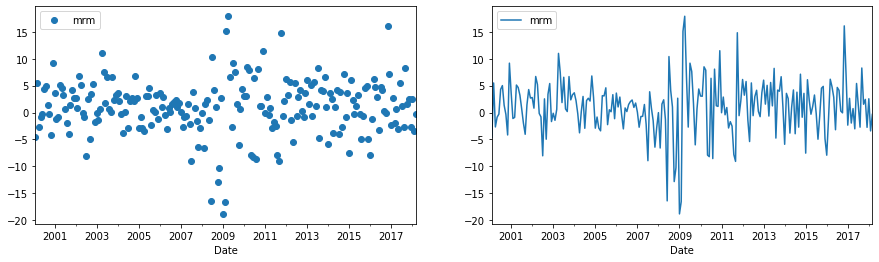

In [1209]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
data.plot(y="mrm", style='o', ax=axes[0])
excess_returns.plot(ax=axes[1])

## 4. Building Linear Regression Model <a class="anchor" id="BuildingLinearRegressionModel"></a>

### 4.1. Standarize

In [1210]:
features_scaled = StandardScaler().fit_transform(features)

### 4.2. Split the data into train and test sets

In [1211]:
X_train, X_test, Y_train, Y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=5)

### 4.3. Build Regression Model

In [1212]:
regression = LinearRegression()
regression.fit(X_train, Y_train)
y_pred = regression.predict(X_test)

## 5. Model evaluation <a class="anchor" id="ModelEvaluation"></a>

### 5.1. R-Squared, MSE and MAE

In [1213]:
print("R-Squared: {}".format(regression.score(X_test, Y_test)))                                                                                         
print("Mean squared error (MSE): {}".format(mean_squared_error(Y_test, y_pred)))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(Y_test, y_pred)))        

R-Squared: 0.8057036899376938
Mean squared error (MSE): 4.20447443249376
Mean absolute error (MAE): 1.5128848781463473


### 5.2. Parameters learnt in training

In [1214]:
print("The intercept (beta_0): {}".format(regression.intercept_))

for i, col_name in enumerate(features.columns):
    print("The coefficient (beta_{}) for {}: {}".format(i+1, col_name, regression.coef_[i]))

The intercept (beta_0): 0.9962635669202994
The coefficient (beta_1) for Mkt-RF: 3.6018172729134945
The coefficient (beta_2) for SMB: 1.0354025584428788
The coefficient (beta_3) for HML: 2.669854312193382
The coefficient (beta_4) for RMW: -0.20768615971808835
The coefficient (beta_5) for CMA: -0.43446978315945206


Text(0.5, 1.0, 'Parameters')

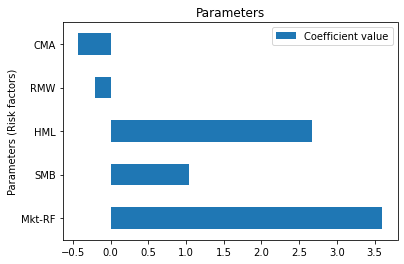

In [1215]:
sorted_coef = sorted(regression.coef_.tolist(), reverse = True)
df = pd.DataFrame({'Parameters (Risk factors)':features.columns, 'Coefficient value': regression.coef_})
ax = df.plot.barh(x='Parameters (Risk factors)', y='Coefficient value')
plt.title("Parameters")

### 5.3. Metrics visualization

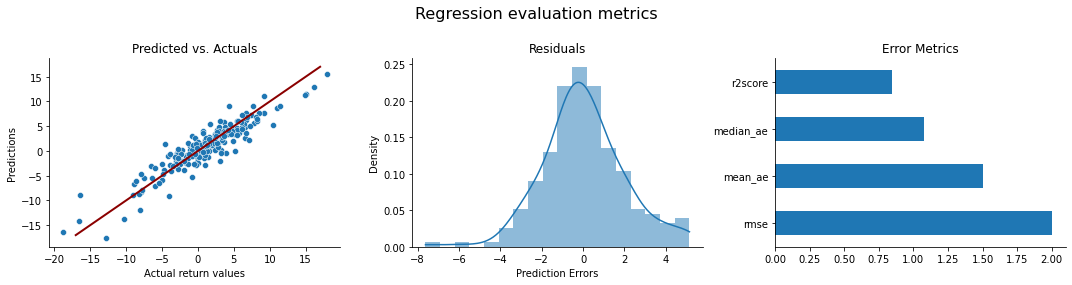

In [1219]:
y_pred=  regression.predict(features_scaled)
y= target    
error = (y - y_pred).rename('Prediction Errors')
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))

scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    #rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
pd.Series(y_range, index=y_range).plot(ax=axes[0], lw=2, c='darkred')
axes[0].set_xlabel('Actual return values')
axes[0].set_ylabel('Predictions')
axes[0].set_title('Predicted vs. Actuals')
sns.histplot(error,kde=True, stat="density", linewidth=0, ax=axes[1])
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('Regression evaluation metrics', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.80)

### 5.3. Information Coefficient

In [1220]:
lr_r, lr_p = spearmanr(y, y_pred)
print(f'Information Coefficient: {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient: 89.432% (p-value: 0.0000%)
